In [20]:
import os

from dotenv import load_dotenv, find_dotenv

from langchain_openai import ChatOpenAI

from database.schemas import meta
from database.manager import PostgresAlchemyManager
from agent.mas import (
    CoffeeShopAnalystAsistant,
    provide_agentic_session
)

MODEL_NAME: str = "qwen3-32b"

load_dotenv(find_dotenv())

database_manager = PostgresAlchemyManager(
    postgres_dsn=os.getenv("POSTGRES_DSN"),
    metadata=meta
)
llm = ChatOpenAI(
    base_url=os.getenv("BASE_URL"),
    api_key=os.getenv("LLM_API_KEY"),
    model=os.getenv("MODEL_NAME") or MODEL_NAME
)
agent = CoffeeShopAnalystAsistant(
    llm=llm,
    database_manager=database_manager,
    max_interactions_count=5,
    fallback_temperature=0.3
)

In [12]:
app = agent.compiled_graph

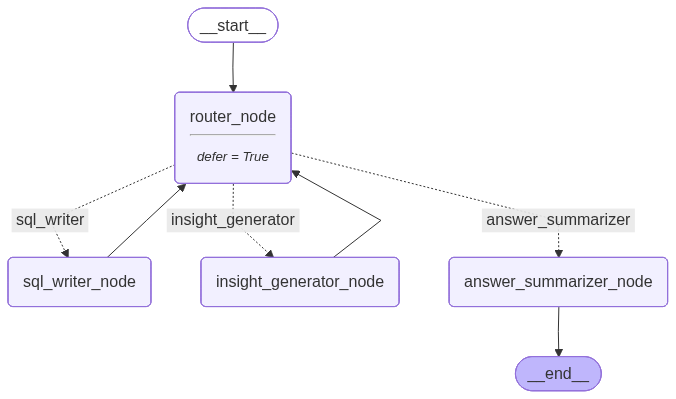

In [8]:
display(app)

In [3]:
# Вопрос по написанию релевантного доступной базе данных SQL-запроса

answer = await app.ainvoke({"request": "Hi! Write me SQL-query that finds the top-5 transacions by transactions_qty"})

Routing decision: sql_writer
Routing decision: answer_summarizer


In [4]:
print(answer["answer"].answer)

Here is your SQL query: 

```sql
SELECT transaction_id, transaction_qty FROM transactions_t ORDER BY transaction_qty DESC LIMIT 5;
```

This query retrieves the top 5 transactions with the highest transaction quantities. 🚀📊


In [ ]:
# Совсем общий вопрос, за рамками скоупа системы

general_answer = await app.ainvoke({"request": "Hi! What is the ReAct pattern for designing agent systems?"})

Routing decision: general_question


In [6]:
print(general_answer["answer"])



The **ReAct** pattern (Reason + Act) is a design approach for AI agents that combines **reasoning** (planning, thinking) and **acting** (executing actions) in a loop. It helps agents solve complex tasks by alternating between:  

1️⃣ **Reasoning**: Analyzing the task, planning steps, or inferring what to do next.  
2️⃣ **Acting**: Taking concrete actions (e.g., API calls, data retrieval, tool use).  

**Example**: A QA agent using ReAct might first *reason* about how to find an answer (e.g., "I need to look up the population of Paris"), then *act* by searching the web.  

**Why it works**: Balances deliberation and action, improving performance in tasks requiring both planning and execution. 🤖💡  

*Source: Inspired by the 2023 paper "ReAct: Symbolic-Reasoning-Augmented Language Models for Commonsense Reasoning."*


In [5]:
# Вопрос по изменению архитектуры базы данных + немного генерации кода.

architectural_question = await app.ainvoke({"request": "Hi! Help me design an update to the products_t directory in our database. You can also write me an SQL query for this."})

Routing decision: sql_writer


In [6]:
print(architectural_question["answer"].answer)

I'm ready to help you design an update and write the SQL query. Just let me know what specific changes you'd like to implement in the products_t directory! 🛠️


In [ ]:
# Теперь имеет смысл использовать сессионный режим для того, чтобы задать несколько целевых вопросов системе
# Также, при использовании такого режима, у нас появляется удобный доступ к дампу session_trace в развернутом PostgreSQL

analytical_sql = """
    select count(transaction_id) as sales_cnt, product_id, product_name, calories, protein  from transactions_t 
    left join products_t p using(product_id)
    left join nutritions_t n using(product_id)
    where calories > 100 and protein > 10
    group by product_id, product_name, calories, protein
    order by sales_cnt desc
"""

name = "Starbucks® Signature Hot Chocolate"

requests = [
    "Hi! Explain me that analytical SQL code snippet: {code}",
    "Perform a descriptive analysis of the transactions_t table in the database",
    "Write me an SQL query to calculate the most frequent transaction time for the date 2023-06-30"
]

await provide_agentic_session(agent)

Routing decision: sql_writer
Routing decision: answer_summarizer
✨ Here's a breakdown of the SQL query:

1. **Counting Sales**: The query uses `COUNT(transaction_id)` to count how many times each product was purchased, naming the result `sales_cnt`.

2. **Joining Tables**: It joins the `transactions_t`, `products_t`, and `nutritions_t` tables using the `product_id` field to gather product names and nutritional information.

3. **Filtering Criteria**: Only products with more than 100 calories and more than 10 grams of protein are included in the results.

4. **Grouping and Sorting**: The results are grouped by `product_id`, `product_name`, `calories`, and `protein` to ensure accurate counts, and then sorted by `sales_cnt` in descending order to show the most popular products at the top.
Routing decision: sql_writer
Routing decision: answer_summarizer
Here's the SQL query to calculate the most frequent transaction time for June 30, 2023:

```sql
SELECT transaction_time, COUNT(*) AS trans